# 机器学习纳米学位
## 非监督学习
## 项目 3: 创建用户分类

欢迎来到机器学习工程师纳米学位的第三个项目！在这个notebook文件中，有些模板代码已经提供给你，但你还需要实现更多的功能来完成这个项目。除非有明确要求，你无须修改任何已给出的代码。以**'练习'**开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以**'TODO'**标出。请仔细阅读所有的提示！

除了实现代码外，你还**必须**回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

>**提示：**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

In [167]:
# 引入这个项目需要的库
import numpy as np
import pandas as pd
import visuals as vs
from IPython.display import display # 使得我们可以对DataFrame使用display()函数

# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline

# 载入整个客户数据集
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## 分析数据
在这部分，你将开始分析数据，通过可视化和代码来理解每一个特征和其他特征的联系。你会看到关于数据集的统计描述，考虑每一个属性的相关性，然后从数据集中选择若干个样本数据点，你将在整个项目中一直跟踪研究这几个数据点。

运行下面的代码单元给出数据集的一个统计描述。注意这个数据集包含了6个重要的产品类型：**'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**和 **'Delicatessen'**。想一下这里每一个类型代表你会购买什么样的产品。

In [168]:
# 显示数据集的一个描述
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### 练习: 选择样本
为了对客户有一个更好的了解，并且了解代表他们的数据将会在这个分析过程中如何变换。最好是选择几个样本数据点，并且更为详细地分析它们。在下面的代码单元中，选择**三个**索引加入到索引列表`indices`中，这三个索引代表你要追踪的客户。我们建议你不断尝试，直到找到三个明显不同的客户。

In [169]:
# TODO：从数据集中选择三个你希望抽样的数据点的索引【生鲜、奶制品、杂货、冷冻食品、洗涤剂纸巾、熟食】
indices = [4,9,23]

# 为选择的样本建立一个DataFrame
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,22615,5410,7198,3915,1777,5185
1,6006,11093,18881,1159,7425,2098
2,26373,36423,22019,5154,4337,16523


### 问题 1
*在你看来你选择的这三个样本点分别代表什么类型的企业（客户）？*对每一个你选择的样本客户，通过它在每一种产品类型上的花费与数据集的统计描述进行比较，给出你做上述判断的理由。


**提示：** 企业的类型包括超市、咖啡馆、零售商以及其他。注意不要使用具体企业的名字，比如说在描述一个餐饮业客户时，你不能使用麦当劳。

**回答:4比较像生鲜市场零售商，因为它主要采购的是fresh；9比较像杂货零售商，因为它采购的主要是grocery；23像是超市，因为它采购的各种商品量都比较大。**

### 练习: 特征相关性
一个有趣的想法是，考虑这六个类别中的一个（或者多个）产品类别，是否对于理解客户的购买行为具有实际的相关性。也就是说，当用户购买了一定数量的某一类产品，我们是否能够确定他们必然会成比例地购买另一种类的产品。有一个简单的方法可以检测相关性：我们用移除了某一个特征之后的数据集来构建一个监督学习（回归）模型，然后用这个模型去预测那个被移除的特征，再对这个预测结果进行评分，来判断由余下5个特征构建的模型对移除掉的那一个特征预测能力的好坏。

在下面的代码单元中，你需要实现以下的功能：
 - 使用`DataFrame.drop`函数移除数据集中你选择的不需要的特征，并将移除后的结果赋值给`new_data`。
 - 使用`sklearn.model_selection.train_test_split`将数据集分割成训练集和测试集。
   - 使用移除的特征作为你的目标标签。设置`test_size`为`0.25`并设置一个`random_state`。
 - 导入一个DecisionTreeRegressor（决策树回归器），设置一个`random_state`，然后用训练集训练它。
 - 使用回归器的`score`函数输出模型在测试集上的预测得分。

In [170]:
# TODO：为DataFrame创建一个副本，用'drop'函数丢弃一些指定的特征

Milk = data['Milk']
new_data = data.drop('Milk', axis = 1)

# TODO：使用给定的特征作为目标，将数据分割成训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data,Milk,test_size=0.25, random_state=42)

# TODO：创建一个DecisionTreeRegressor（决策树回归器）并在训练集上训练它
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV#过拟合的模型所得出的结论没有意义
param = {'max_depth':range(1,10), 'min_samples_split':range(2,10), 'min_samples_leaf':range(1,10)}
regressor = GridSearchCV(DecisionTreeRegressor(), param)
regressor = regressor.fit(X_train,y_train)
print regressor.best_params_

# TODO：输出在测试集上的预测得分
score = regressor.score(X_test,y_test)
print score

{'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 8}
0.553243992541


### 问题 2
*你尝试预测哪一个特征？预测的得分是多少？这个特征对于区分用户的消费习惯来说必要吗？*  
**提示：** 决定系数（coefficient of determination）, `R^2`,结果在0到1之间，1表示完美拟合，一个负的`R^2`表示模型不能够拟合数据。

**回答:预测了Milk特征，预测的得分是0.55，这个特征对于区分用户的消费习惯来说没有必要，因为它与其他特征仅表现出弱相关性。**

### 可视化特征分布
为了能够对这个数据集有一个更好的理解，我们可以对数据集中的每一个产品特征构建一个散布矩阵（scatter matrix）。如果你发现你在上面尝试预测的特征对于区分一个特定的用户来说是必须的，那么这个特征和其它的特征可能不会在下面的散射矩阵中显示任何关系。相反的，如果你认为这个特征对于识别一个特定的客户是没有作用的，那么通过散布矩阵可以看出在这个数据特征和其它特征中有关联性。运行下面的代码以创建一个散布矩阵。

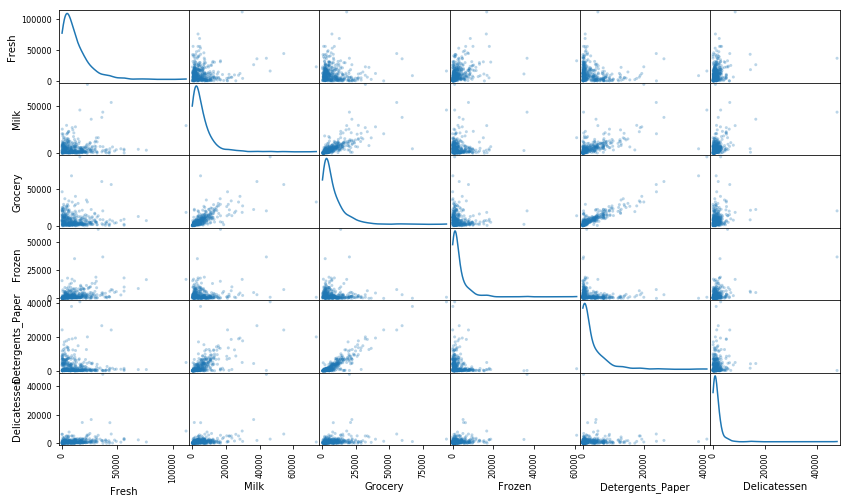

In [171]:
# 对于数据中的每一对特征构造一个散布矩阵
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### 问题 3
*这里是否存在一些特征他们彼此之间存在一定程度相关性？如果有请列出。这个结果是验证了还是否认了你尝试预测的那个特征的相关性？这些特征的数据是怎么分布的？*

**提示：** 这些数据是正态分布(normally distributed)的吗？大多数的数据点分布在哪？

**回答:从这里可以看出，Milk、Grocery与Detergents_papaer之间存在着一定的线性相关性。这个结果在一定程度上验证了我尝试预测的特征相关性。由散布矩阵图中坐标为[1,1]、[2,2]、[3,3]、[4,4]、[5,5]、[6,6]的图可以看出各个特征的数据均是符合正态分布的。大多数的数据点分布在相对较低的消费水平区间。**

## 数据预处理
在这个部分，你将通过在数据上做一个合适的缩放，并检测异常点（你可以选择性移除）将数据预处理成一个更好的代表客户的形式。预处理数据是保证你在分析中能够得到显著且有意义的结果的重要环节。

### 练习: 特征缩放
如果数据不是正态分布的，尤其是数据的平均数和中位数相差很大的时候（表示数据非常歪斜）。这时候通常用一个非线性的缩放是[很合适的](https://github.com/czcbangkai/translations/blob/master/use_of_logarithms_in_economics/use_of_logarithms_in_economics.pdf)，[（英文原文）](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) — 尤其是对于金融数据。一种实现这个缩放的方法是使用[Box-Cox 变换](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html)，这个方法能够计算出能够最佳减小数据倾斜的指数变换方法。一个比较简单的并且在大多数情况下都适用的方法是使用自然对数。

在下面的代码单元中，你将需要实现以下功能：
 - 使用`np.log`函数在数据 `data` 上做一个对数缩放，然后将它的副本（不改变原始data的值）赋值给`log_data`。
 - 使用`np.log`函数在样本数据 `samples` 上做一个对数缩放，然后将它的副本赋值给`log_samples`。

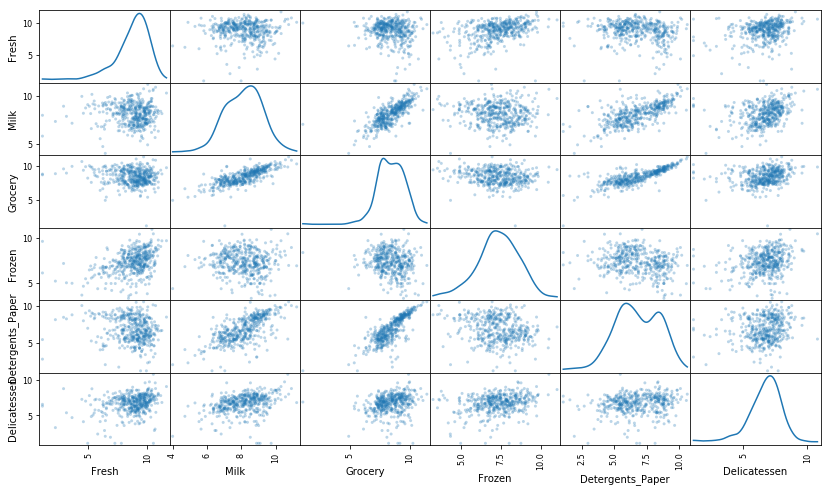

In [172]:
# TODO：使用自然对数缩放数据
log_data = np.log(data)

# TODO：使用自然对数缩放样本数据
log_samples = np.log(samples)

# 为每一对新产生的特征制作一个散射矩阵
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### 观察
在使用了一个自然对数的缩放之后，数据的各个特征会显得更加的正态分布。对于任意的你以前发现有相关关系的特征对，观察他们的相关关系是否还是存在的（并且尝试观察，他们的相关关系相比原来是变强了还是变弱了）。

运行下面的代码以观察样本数据在进行了自然对数转换之后如何改变了。

In [173]:
# 展示经过对数变换后的样本数据
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
1,8.700514,9.314070,9.845911,7.055313,8.912608,7.648740
2,10.180096,10.502956,9.999661,8.547528,8.374938,9.712509


### 练习: 异常值检测
对于任何的分析，在数据预处理的过程中检测数据中的异常值都是非常重要的一步。异常值的出现会使得把这些值考虑进去后结果出现倾斜。这里有很多关于怎样定义什么是数据集中的异常值的经验法则。这里我们将使用[Tukey的定义异常值的方法](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/)：一个*异常阶（outlier step）*被定义成1.5倍的四分位距（interquartile range，IQR）。一个数据点如果某个特征包含在该特征的IQR之外的特征，那么该数据点被认定为异常点。

在下面的代码单元中，你需要完成下面的功能：
 - 将指定特征的25th分位点的值分配给`Q1`。使用`np.percentile`来完成这个功能。
 - 将指定特征的75th分位点的值分配给`Q3`。同样的，使用`np.percentile`来完成这个功能。
 - 将指定特征的异常阶的计算结果赋值给`step`.
 - 选择性地通过将索引添加到`outliers`列表中，以移除异常值。

**注意：** 如果你选择移除异常值，请保证你选择的样本点不在这些移除的点当中！
一旦你完成了这些功能，数据集将存储在`good_data`中。

In [193]:
# 对于每一个特征，找到值异常高或者是异常低的数据点
outline=[]
outlines=[]
for feature in log_data.keys():
    
    # TODO：计算给定特征的Q1（数据的25th分位点）
    Q1 = np.percentile(log_data,25)
    
    # TODO：计算给定特征的Q3（数据的75th分位点）
    Q3 = np.percentile(log_data,75)
    
    # TODO：使用四分位范围计算异常阶（1.5倍的四分位距）
    step = 1.5*(Q3-Q1)
#记录异常值    
    for i in log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index:
        outline.append(i)
    # 显示异常点
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
#记录出现多次的异常值    
    for i in range(0,len(outline)):
        if outline.count(outline[i])>1:        
            outlines.append(outline[i])
#输出出现多次的异常值
#print set(outline)
#print set(outlines)

# 可选：选择你希望移除的数据点的索引
outliers  = [128, 137, 109, 402, 285, 161, 420, 38, 177, 184, 187, 65, 203, 204, 218, 95, 96, 356, 233, 237, 122]

# 如果选择了的话，移除异常点
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
122,9.410174,5.303305,5.501258,7.596392,3.218876,6.756932
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101
177,9.453992,8.899731,8.419139,7.468513,2.995732,7.875119
204,7.578657,6.792344,8.561401,7.232010,1.609438,7.191429
237,9.835851,8.252707,6.385194,8.441176,3.332205,7.102499
289,10.663966,5.655992,6.154858,7.235619,3.465736,3.091042
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372
233,6.871091,8.513988,8.106515,6.842683,6.013715,1.945910


### 问题 4
*请列出所有在多于一个特征下被看作是异常的数据点。这些点应该被从数据集中移除吗？为什么？把你认为需要移除的数据点全部加入到到`outliers`变量中。* 

**回答:索引为289, 66, 75, 142, 338, 154的数据点都是在多于一个特征下被看作是异常的数据点。这些点不应该被从数据集中移除，因为他们仍然可以呈现出多个特征之间的相关性信息。我选择把不能展现Milk、Grocery、Detergents_Paper相关性的异常值全部移除**

## 特征转换
在这个部分中你将使用主成分分析（PCA）来分析批发商客户数据的内在结构。由于使用PCA在一个数据集上会计算出最大化方差的维度，我们将找出哪一个特征组合能够最好的描绘客户。

### 练习: 主成分分析（PCA）

既然数据被缩放到一个更加正态分布的范围中并且我们也移除了需要移除的异常点，我们现在就能够在`good_data`上使用PCA算法以发现数据的哪一个维度能够最大化特征的方差。除了找到这些维度，PCA也将报告每一个维度的*解释方差比（explained variance ratio）*--这个数据有多少方差能够用这个单独的维度来解释。注意PCA的一个组成部分（维度）能够被看做这个空间中的一个新的“特征”，但是它是原来数据中的特征构成的。

在下面的代码单元中，你将要实现下面的功能：
 - 导入`sklearn.decomposition.PCA`并且将`good_data`用PCA并且使用6个维度进行拟合后的结果保存到`pca`中。
 - 使用`pca.transform`将`log_samples`进行转换，并将结果存储到`pca_samples`中。

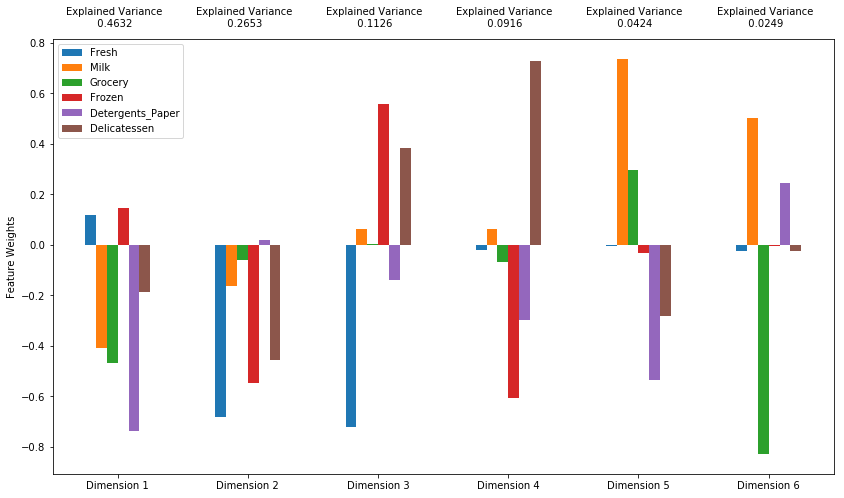

In [175]:
# TODO：通过在good data上使用PCA，将其转换成和当前特征数一样多的维度
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(good_data)
# TODO：使用上面的PCA拟合将变换施加在log_samples上
pca_samples = pca.transform(log_samples)

# 生成PCA的结果图
pca_results = vs.pca_results(good_data, pca)

### 问题 5
*数据的第一个和第二个主成分* **总共** *表示了多少的方差？*  前四个主成分呢？使用上面提供的可视化图像，讨论从用户花费的角度来看前四个**主要成分**的消费行为最能代表哪种类型的客户并给出你做出判断的理由。

**提示：** 某一特定维度上的正向增长对应**正权**特征的**增长**和**负权**特征的**减少**。增长和减少的速率和每个特征的权重相关。[参考资料(英文)](https://onlinecourses.science.psu.edu/stat505/node/54)。

**回答:数据的前两个主成分总共表示了0.719方差，前四个主成分总共表示了0.9347方差。从用户花费的角度来看，Dimension1最能代表同时大量采购杂货、奶制品和清洁剂、小量采购生鲜和冷冻食品的杂货零售类客户；Dimension2最能代表同时大量采购生鲜、冷冻食品和熟食的食品零售类客户；Dimension3最能代表大量采购生鲜、冷冻食品与熟食的快餐类客户；Dimension4最能代表大量采购冷冻食品、熟食与清洁剂的小吃类客户**

### 观察
运行下面的代码，查看经过对数转换的样本数据在进行一个6个维度的主成分分析（PCA）之后会如何改变。观察样本数据的前四个维度的数值。考虑这和你初始对样本点的解释是否一致。

In [176]:
# 展示经过PCA转换的sample log-data
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-0.9223,-2.2427,0.2636,0.5509,-0.4146,-0.0425
1,-2.8913,-0.4041,0.0466,0.2058,-0.0623,-0.0726
2,-3.0394,-3.3798,0.7478,1.0049,0.5132,0.1784


### 练习：降维
当使用主成分分析的时候，一个主要的目的是减少数据的维度，这实际上降低了问题的复杂度。当然降维也是需要一定代价的：更少的维度能够表示的数据中的总方差更少。因为这个，*累计解释方差比（cumulative explained variance ratio）*对于我们确定这个问题需要多少维度非常重要。另外，如果大部分的方差都能够通过两个或者是三个维度进行表示的话，降维之后的数据能够被可视化。

在下面的代码单元中，你将实现下面的功能：
 - 将`good_data`用两个维度的PCA进行拟合，并将结果存储到`pca`中去。
 - 使用`pca.transform`将`good_data`进行转换，并将结果存储在`reduced_data`中。
 - 使用`pca.transform`将`log_samples`进行转换，并将结果存储在`pca_samples`中。

In [177]:
# TODO：通过在good data上进行PCA，将其转换成两个维度
pca = PCA(n_components=2)
pca.fit(good_data)
# TODO：使用上面训练的PCA将good data进行转换
reduced_data = pca.transform(good_data)

# TODO：使用上面训练的PCA将log_samples进行转换
pca_samples = pca.transform(log_samples)

# 为降维后的数据创建一个DataFrame
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### 观察
运行以下代码观察当仅仅使用两个维度进行PCA转换后，这个对数样本数据将怎样变化。观察这里的结果与一个使用六个维度的PCA转换相比较时，前两维的数值是保持不变的。

In [178]:
# 展示经过两个维度的PCA转换之后的样本log-data
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-0.9223,-2.2427
1,-2.8913,-0.4041
2,-3.0394,-3.3798


## 可视化一个双标图（Biplot）
双标图是一个散点图，每个数据点的位置由它所在主成分的分数确定。坐标系是主成分（这里是`Dimension 1` 和 `Dimension 2`）。此外，双标图还展示出初始特征在主成分上的投影。一个双标图可以帮助我们理解降维后的数据，发现主成分和初始特征之间的关系。

运行下面的代码来创建一个降维后数据的双标图。

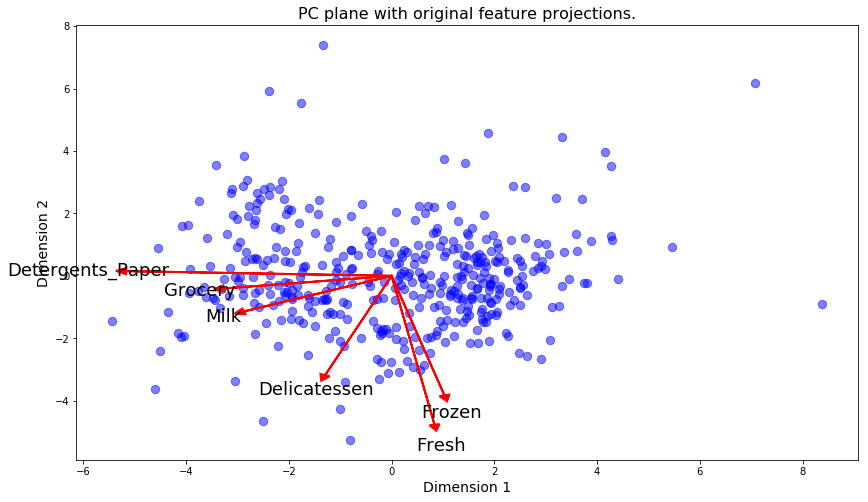

In [179]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### 观察

一旦我们有了原始特征的投影（红色箭头），就能更加容易的理解散点图每个数据点的相对位置。

在这个双标图中，哪些初始特征与第一个主成分有强关联？哪些初始特征与第二个主成分相关联？你观察到的是否与之前得到的 pca_results 图相符？

## 聚类

在这个部分，你将选择使用K-Means聚类算法或者是高斯混合模型聚类算法以发现数据中隐藏的客户分类。然后，你将从簇中恢复一些特定的关键数据点，通过将它们转换回原始的维度和规模，从而理解他们的含义。

### 问题 6
*使用K-Means聚类算法的优点是什么？使用高斯混合模型聚类算法的优点是什么？基于你现在对客户数据的观察结果，你选用了这两个算法中的哪一个，为什么？*

**回答:
-使用K-Means聚类算法的优点是（1）易于实现，易于理解与解释；（2）不需要labels;(3)计算量相对不大，收敛快。
-使用高斯混合模型聚类算法的优点是（1）理论上可以拟合任何连续函数。（2）不需要labels
-基于我现在对客户数据的观察结果，我选用K-means算法，因为应用高斯混合模型时，要求全部特征各自形成独立的高斯分布前，本身也应该满足同一个独立的高斯分布假设，这里的数据显示存在两种分布，一种是小型零售商，服从小批量的采购量分布，另一种是超市等大型零售商，服从大批量的采购量分布，明显不服从同一个独立的高斯分布。**

### 练习: 创建聚类

针对不同情况，有些问题你需要的聚类数目可能是已知的。但是在聚类数目不作为一个**先验**知道的情况下，我们并不能够保证某个聚类的数目对这个数据是最优的，因为我们对于数据的结构（如果存在的话）是不清楚的。但是，我们可以通过计算每一个簇中点的**轮廓系数**来衡量聚类的质量。数据点的[轮廓系数](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)衡量了它与分配给他的簇的相似度，这个值范围在-1（不相似）到1（相似）。**平均**轮廓系数为我们提供了一种简单地度量聚类质量的方法。

在接下来的代码单元中，你将实现下列功能：
 - 在`reduced_data`上使用一个聚类算法，并将结果赋值到`clusterer`，需要设置 `random_state` 使得结果可以复现。
 - 使用`clusterer.predict`预测`reduced_data`中的每一个点的簇，并将结果赋值到`preds`。
 - 使用算法的某个属性值找到聚类中心，并将它们赋值到`centers`。
 - 预测`pca_samples`中的每一个样本点的类别并将结果赋值到`sample_preds`。
 - 导入sklearn.metrics.silhouette_score包并计算`reduced_data`相对于`preds`的轮廓系数。
   - 将轮廓系数赋值给`score`并输出结果。

In [186]:
# TODO：在降维后的数据上使用你选择的聚类算法
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=2, random_state=0).fit(reduced_data)

# TODO：预测每一个点的簇
preds = clusterer.predict(reduced_data)

# TODO：找到聚类中心
centers = clusterer.cluster_centers_

# TODO：预测在每一个转换后的样本点的类
sample_preds = clusterer.predict(pca_samples)

# TODO：计算选择的类别的平均轮廓系数（mean silhouette coefficient）
from sklearn.metrics import silhouette_score
score = silhouette_score(reduced_data,preds)
print score

0.431377930504


### 问题 7

*汇报你尝试的不同的聚类数对应的轮廓系数。在这些当中哪一个聚类的数目能够得到最佳的轮廓系数？* 

**回答:聚类数为2时，轮廓系数为0.4314；聚类数为3时，轮廓系数为0.3393；聚类数为4时，轮廓系数为0.3309；聚类数为5时，轮廓系数为0.3471；聚类数为6时，轮廓系数为0.3688；聚类数为7时，轮廓系数为0.3592。已知轮廓系数越大，聚类的轮廓越清晰，重叠越小。在这些聚类数目中，选取聚类数目为2时，可以得到最佳的轮廓系数。**

### 聚类可视化
一旦你选好了通过上面的评价函数得到的算法的最佳聚类数目，你就能够通过使用下面的代码块可视化来得到的结果。作为实验，你可以试着调整你的聚类算法的聚类的数量来看一下不同的可视化结果。但是你提供的最终的可视化图像必须和你选择的最优聚类数目一致。

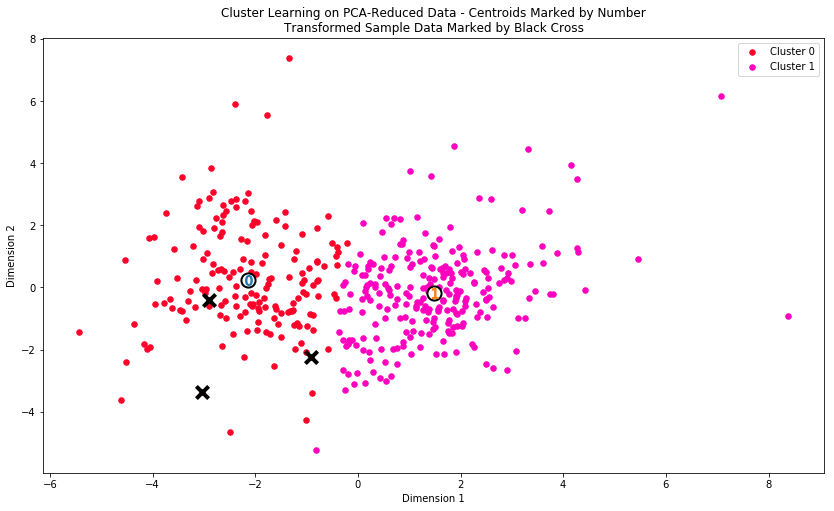

In [187]:
# 从已有的实现中展示聚类的结果
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### 练习: 数据恢复
上面的可视化图像中提供的每一个聚类都有一个中心点。这些中心（或者叫平均点）并不是数据中真实存在的点，但是是所有预测在这个簇中的数据点的*平均*。对于创建客户分类的问题，一个簇的中心对应于*那个分类的平均用户*。因为这个数据现在进行了降维并缩放到一定的范围，我们可以通过施加一个反向的转换恢复这个点所代表的用户的花费。

在下面的代码单元中，你将实现下列的功能：
 - 使用`pca.inverse_transform`将`centers` 反向转换，并将结果存储在`log_centers`中。
 - 使用`np.log`的反函数`np.exp`反向转换`log_centers`并将结果存储到`true_centers`中。


In [190]:
# TODO：反向转换中心点
log_centers = pca.inverse_transform(centers)

# TODO：对中心点做指数转换
true_centers = np.exp(log_centers)

# 显示真实的中心点
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,4346.0,7844.0,12478.0,994.0,4572.0,1124.0
Segment 1,8962.0,1904.0,2363.0,2139.0,313.0,699.0


### 问题 8
考虑上面的代表性数据点在每一个产品类型的花费总数，*你认为这些客户分类代表了哪类客户？为什么？*需要参考在项目最开始得到的统计值来给出理由。

**提示：** 一个被分到`'Cluster X'`的客户最好被用 `'Segment X'`中的特征集来标识的企业类型表示。

**回答:Segment 0代表了日用品类零售商客户，因为它主要采购日用品。Segment 1代表了食品类客户，因为该分类要与Segment 0区别开来，且其采购商品多以食物为主。**

### 问题 9
*对于每一个样本点 * **问题 8**  *中的哪一个分类能够最好的表示它？你之前对样本的预测和现在的结果相符吗？*

运行下面的代码单元以找到每一个样本点被预测到哪一个簇中去。

In [189]:
# 显示预测结果
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 0


**回答:如数据显示：对于每一个样本点，问题8中的Cluster 0 能最好的表示它。与之前对样本的预测和现在的结果不完全相符,Sample point 0之前预测为生鲜类零售商，现在被分为日用品类零售商不太合适；Sample point 1之前预测为杂货类零售商，现在被分为日用品类零售商较合适；Sample point 3之前预测为超市，现在被分为杂货类零售商也较合适。**

## 结论

在最后一部分中，你要学习如何使用已经被分类的数据。首先，你要考虑不同组的客户**客户分类**，针对不同的派送策略受到的影响会有什么不同。其次，你要考虑到，每一个客户都被打上了标签（客户属于哪一个分类）可以给客户数据提供一个多一个特征。最后，你会把客户分类与一个数据中的隐藏变量做比较，看一下这个分类是否辨识了特定的关系。

### 问题 10
在对他们的服务或者是产品做细微的改变的时候，公司经常会使用[A/B tests](https://en.wikipedia.org/wiki/A/B_testing)以确定这些改变会对客户产生积极作用还是消极作用。这个批发商希望考虑将他的派送服务从每周5天变为每周3天，但是他只会对他客户当中对此有积极反馈的客户采用。*这个批发商应该如何利用客户分类来知道哪些客户对它的这个派送策略的改变有积极的反馈，如果有的话？你需要给出在这个情形下A/B 测试具体的实现方法，以及最终得出结论的依据是什么？*  
**提示：** 我们能假设这个改变对所有的客户影响都一致吗？我们怎样才能够确定它对于哪个类型的客户影响最大？

**回答：我们不能假设这个改变对所有的客户影响都一致，但我们有理由认为当某些客户同属于一个客户分类时，我们这个改变对他们的影响更可能一致。由于同一些客户他们可能同存属于不同层面的多个分类当中，我们需要逐一进行A/B测试，试探这个改变会对什么具体层面的分类产生最大影响，从而根据这个层面的分类对应的客户反应，采取合适的决策。**

### 问题 11
通过聚类技术，我们能够将原有的没有标记的数据集中的附加结构分析出来。因为每一个客户都有一个最佳的划分（取决于你选择使用的聚类算法），我们可以把*用户分类*作为数据的一个[**工程特征**](https://en.wikipedia.org/wiki/Feature_learning#Unsupervised_feature_learning)。假设批发商最近迎来十位新顾客，并且他已经为每位顾客每个产品类别年度采购额进行了预估。进行了这些估算之后，批发商该如何运用它的预估和**非监督学习的结果**来对这十个新的客户进行更好的预测？

**提示：**在下面的代码单元中，我们提供了一个已经做好聚类的数据（聚类结果为数据中的cluster属性），我们将在这个数据集上做一个小实验。尝试运行下面的代码看看我们尝试预测‘Region’的时候，如果存在聚类特征'cluster'与不存在相比对最终的得分会有什么影响？这对你有什么启发？

In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 读取包含聚类结果的数据
cluster_data = pd.read_csv("cluster.csv")
y = cluster_data['Region']
X = cluster_data.drop(['Region'], axis = 1)

# 划分训练集测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=24)

clf = RandomForestClassifier(random_state=24)
clf.fit(X_train, y_train)
print "使用cluster特征的得分", clf.score(X_test, y_test)

# 移除cluster特征
X_train = X_train.copy()
X_train.drop(['cluster'], axis=1, inplace=True)
X_test = X_test.copy()
X_test.drop(['cluster'], axis=1, inplace=True)
clf.fit(X_train, y_train)
print "不使用cluster特征的得分", clf.score(X_test, y_test)

使用cluster特征的得分 0.666666666667
不使用cluster特征的得分 0.64367816092


**回答：在尝试预测Region时，使用或不使用聚类特征'cluster'对最终预测准确率score并没有明显差异，我认为cluster特征并非主要的影响特征，在实际预测时为求节约成本可排除该特征。这也意味着，我们可以沿用过去积累的主要特征来预测任意新特征。**

### 可视化内在的分布

在这个项目的开始，我们讨论了从数据集中移除`'Channel'`和`'Region'`特征，这样在分析过程中我们就会着重分析用户产品类别。通过重新引入`Channel`这个特征到数据集中，并施加和原来数据集同样的PCA变换的时候我们将能够发现数据集产生一个有趣的结构。

运行下面的代码单元以查看哪一个数据点在降维的空间中被标记为`'HoReCa'` (旅馆/餐馆/咖啡厅)或者`'Retail'`。另外，你将发现样本点在图中被圈了出来，用以显示他们的标签。

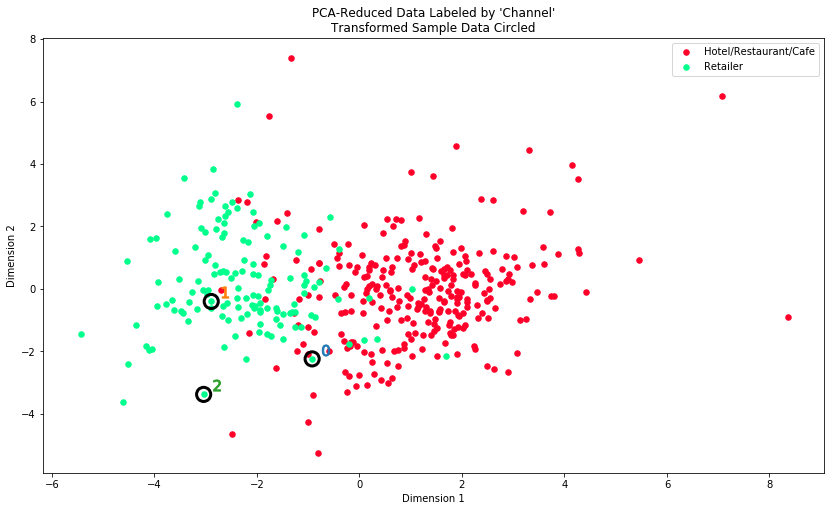

In [192]:
# 根据‘Channel‘数据显示聚类的结果
vs.channel_results(reduced_data, outliers, pca_samples)

### 问题 12

*你选择的聚类算法和聚类点的数目，与内在的旅馆/餐馆/咖啡店和零售商的分布相比，有足够好吗？根据这个分布有没有哪个簇能够刚好划分成'零售商'或者是'旅馆/饭店/咖啡馆'？你觉得这个分类和前面你对于用户分类的定义是一致的吗？*

**回答：我所选择的K-means聚类算法和聚类点的数目，与内在的旅馆/餐馆/咖啡店和零售商的分布相比，并没有足够好，因为我的聚类结果，并没有把它们两者的界限予以明确的划分。根据这个分布，有两个簇能够刚好划分成'零售商'，这个分类和前面我对与用户分类的定义是一致的。**

> **注意**: 当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出**File -> Download as -> HTML (.html)**把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。  